# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [2]:
# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time

#### Default Datentyp

In [3]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [4]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.GELU(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, hidden2_size),
            nn.GELU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.GELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [5]:
model = NeuralNetwork(5, 200, 200, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [6]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file_haber = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten Haber
eq_data_file_picaso = Path.cwd() / 'data' / 'eq_dataset_x_extra.npz' #Import der GGW Daten PICASO

res_haber = np.load(eq_data_file_haber)
res_picaso = np.load(eq_data_file_picaso)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.cat((torch.tensor(res_haber['T']), torch.tensor(res_picaso['T'])), 0)
p = torch.cat((torch.tensor(res_haber['p']), torch.tensor(res_picaso['p'])), 0)
x_0 = torch.cat((torch.tensor(res_haber['x_0']), torch.tensor(res_picaso['x_0'])), 0)
x = torch.cat((torch.tensor(res_haber['x']), torch.tensor(res_picaso['x'])), 0)

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000

#print(T.size())
# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


torch.Size([2000])


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [7]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 2)

# Loss Funktion; gibt Fehler an
loss_fn_MSE = nn.MSELoss()
loss_fn_L1 = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn_MSE(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn_L1(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Runtime measurement
train_time_start = time.process_time()
#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn_MSE(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

train_time = time.process_time() - train_time_start
print('Training time:',train_time, 's')

Epoch 1/200, Iteration 1/25, Loss: 0.6391
Epoch 1/200, Iteration 2/25, Loss: 0.4248
Epoch 1/200, Iteration 3/25, Loss: 0.8410
Epoch 1/200, Iteration 4/25, Loss: 0.2889
Epoch 1/200, Iteration 5/25, Loss: 0.3669
Epoch 1/200, Iteration 6/25, Loss: 0.4014
Epoch 1/200, Iteration 7/25, Loss: 0.4501
Epoch 1/200, Iteration 8/25, Loss: 0.2613
Epoch 1/200, Iteration 9/25, Loss: 0.2036
Epoch 1/200, Iteration 10/25, Loss: 0.1321
Epoch 1/200, Iteration 11/25, Loss: 0.1371
Epoch 1/200, Iteration 12/25, Loss: 0.1776
Epoch 1/200, Iteration 13/25, Loss: 0.1017
Epoch 1/200, Iteration 14/25, Loss: 0.1659
Epoch 1/200, Iteration 15/25, Loss: 0.0753
Epoch 1/200, Iteration 16/25, Loss: 0.1374
Epoch 1/200, Iteration 17/25, Loss: 0.0828
Epoch 1/200, Iteration 18/25, Loss: 0.1166
Epoch 1/200, Iteration 19/25, Loss: 0.0587
Epoch 1/200, Iteration 20/25, Loss: 0.0748
Epoch 1/200, Iteration 21/25, Loss: 0.0694
Epoch 1/200, Iteration 22/25, Loss: 0.0495
Epoch 1/200, Iteration 23/25, Loss: 0.1003
Epoch 1/200, Iterati

Epoch 7/200, Iteration 21/25, Loss: 0.0018
Epoch 7/200, Iteration 22/25, Loss: 0.0126
Epoch 7/200, Iteration 23/25, Loss: 0.0087
Epoch 7/200, Iteration 24/25, Loss: 0.0049
Epoch 7/200, Iteration 25/25, Loss: 0.0091
Train Error: 
 Accuracy: 67.44%, Avg loss: 0.010787, MRE: 0.059173, MAE: 0.010625 

Test Error: 
 Accuracy: 39.5%, Avg loss: 0.024151, MRE: 0.076795, MAE: 0.018001 

Epoch 8/200, Iteration 1/25, Loss: 0.0091
Epoch 8/200, Iteration 2/25, Loss: 0.0044
Epoch 8/200, Iteration 3/25, Loss: 0.0157
Epoch 8/200, Iteration 4/25, Loss: 0.0127
Epoch 8/200, Iteration 5/25, Loss: 0.0041
Epoch 8/200, Iteration 6/25, Loss: 0.0187
Epoch 8/200, Iteration 7/25, Loss: 0.0129
Epoch 8/200, Iteration 8/25, Loss: 0.0099
Epoch 8/200, Iteration 9/25, Loss: 0.0152
Epoch 8/200, Iteration 10/25, Loss: 0.0084
Epoch 8/200, Iteration 11/25, Loss: 0.0096
Epoch 8/200, Iteration 12/25, Loss: 0.0155
Epoch 8/200, Iteration 13/25, Loss: 0.0045
Epoch 8/200, Iteration 14/25, Loss: 0.0061
Epoch 8/200, Iteration 15/

Epoch 14/200, Iteration 19/25, Loss: 0.0016
Epoch 14/200, Iteration 20/25, Loss: 0.0012
Epoch 14/200, Iteration 21/25, Loss: 0.0028
Epoch 14/200, Iteration 22/25, Loss: 0.0017
Epoch 14/200, Iteration 23/25, Loss: 0.0017
Epoch 14/200, Iteration 24/25, Loss: 0.0013
Epoch 14/200, Iteration 25/25, Loss: 0.0011
Train Error: 
 Accuracy: 98.31%, Avg loss: 0.001295, MRE: 0.024491, MAE: 0.004350 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.002550, MRE: 0.033833, MAE: 0.005884 

Epoch 15/200, Iteration 1/25, Loss: 0.0016
Epoch 15/200, Iteration 2/25, Loss: 0.0006
Epoch 15/200, Iteration 3/25, Loss: 0.0008
Epoch 15/200, Iteration 4/25, Loss: 0.0014
Epoch 15/200, Iteration 5/25, Loss: 0.0009
Epoch 15/200, Iteration 6/25, Loss: 0.0018
Epoch 15/200, Iteration 7/25, Loss: 0.0011
Epoch 15/200, Iteration 8/25, Loss: 0.0006
Epoch 15/200, Iteration 9/25, Loss: 0.0023
Epoch 15/200, Iteration 10/25, Loss: 0.0010
Epoch 15/200, Iteration 11/25, Loss: 0.0008
Epoch 15/200, Iteration 12/25, Loss: 0.0006
Epoch 1

Epoch 21/200, Iteration 18/25, Loss: 0.0228
Epoch 21/200, Iteration 19/25, Loss: 0.0191
Epoch 21/200, Iteration 20/25, Loss: 0.0256
Epoch 21/200, Iteration 21/25, Loss: 0.0198
Epoch 21/200, Iteration 22/25, Loss: 0.0168
Epoch 21/200, Iteration 23/25, Loss: 0.0161
Epoch 21/200, Iteration 24/25, Loss: 0.0194
Epoch 21/200, Iteration 25/25, Loss: 0.0169
Train Error: 
 Accuracy: 69.0%, Avg loss: 0.010118, MRE: 0.067550, MAE: 0.011758 

Test Error: 
 Accuracy: 62.5%, Avg loss: 0.022369, MRE: 0.111504, MAE: 0.018925 

Epoch 22/200, Iteration 1/25, Loss: 0.0110
Epoch 22/200, Iteration 2/25, Loss: 0.0144
Epoch 22/200, Iteration 3/25, Loss: 0.0135
Epoch 22/200, Iteration 4/25, Loss: 0.0158
Epoch 22/200, Iteration 5/25, Loss: 0.0097
Epoch 22/200, Iteration 6/25, Loss: 0.0215
Epoch 22/200, Iteration 7/25, Loss: 0.0133
Epoch 22/200, Iteration 8/25, Loss: 0.0256
Epoch 22/200, Iteration 9/25, Loss: 0.0169
Epoch 22/200, Iteration 10/25, Loss: 0.0225
Epoch 22/200, Iteration 11/25, Loss: 0.0279
Epoch 22

Epoch 28/200, Iteration 21/25, Loss: 0.0006
Epoch 28/200, Iteration 22/25, Loss: 0.0006
Epoch 28/200, Iteration 23/25, Loss: 0.0005
Epoch 28/200, Iteration 24/25, Loss: 0.0008
Epoch 28/200, Iteration 25/25, Loss: 0.0004
Train Error: 
 Accuracy: 98.5%, Avg loss: 0.000470, MRE: 0.016441, MAE: 0.002472 

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.001385, MRE: 0.021791, MAE: 0.003764 

Epoch 29/200, Iteration 1/25, Loss: 0.0006
Epoch 29/200, Iteration 2/25, Loss: 0.0005
Epoch 29/200, Iteration 3/25, Loss: 0.0007
Epoch 29/200, Iteration 4/25, Loss: 0.0004
Epoch 29/200, Iteration 5/25, Loss: 0.0005
Epoch 29/200, Iteration 6/25, Loss: 0.0006
Epoch 29/200, Iteration 7/25, Loss: 0.0004
Epoch 29/200, Iteration 8/25, Loss: 0.0007
Epoch 29/200, Iteration 9/25, Loss: 0.0005
Epoch 29/200, Iteration 10/25, Loss: 0.0004
Epoch 29/200, Iteration 11/25, Loss: 0.0006
Epoch 29/200, Iteration 12/25, Loss: 0.0005
Epoch 29/200, Iteration 13/25, Loss: 0.0007
Epoch 29/200, Iteration 14/25, Loss: 0.0004
Epoch 29

Epoch 35/200, Iteration 17/25, Loss: 0.0114
Epoch 35/200, Iteration 18/25, Loss: 0.0159
Epoch 35/200, Iteration 19/25, Loss: 0.0105
Epoch 35/200, Iteration 20/25, Loss: 0.0084
Epoch 35/200, Iteration 21/25, Loss: 0.0121
Epoch 35/200, Iteration 22/25, Loss: 0.0094
Epoch 35/200, Iteration 23/25, Loss: 0.0098
Epoch 35/200, Iteration 24/25, Loss: 0.0094
Epoch 35/200, Iteration 25/25, Loss: 0.0117
Train Error: 
 Accuracy: 86.75%, Avg loss: 0.007517, MRE: 0.065863, MAE: 0.010548 

Test Error: 
 Accuracy: 70.25%, Avg loss: 0.014141, MRE: 0.090166, MAE: 0.014814 

Epoch 36/200, Iteration 1/25, Loss: 0.0063
Epoch 36/200, Iteration 2/25, Loss: 0.0076
Epoch 36/200, Iteration 3/25, Loss: 0.0101
Epoch 36/200, Iteration 4/25, Loss: 0.0105
Epoch 36/200, Iteration 5/25, Loss: 0.0089
Epoch 36/200, Iteration 6/25, Loss: 0.0087
Epoch 36/200, Iteration 7/25, Loss: 0.0055
Epoch 36/200, Iteration 8/25, Loss: 0.0073
Epoch 36/200, Iteration 9/25, Loss: 0.0056
Epoch 36/200, Iteration 10/25, Loss: 0.0101
Epoch 

Epoch 42/200, Iteration 18/25, Loss: 0.0001
Epoch 42/200, Iteration 19/25, Loss: 0.0001
Epoch 42/200, Iteration 20/25, Loss: 0.0001
Epoch 42/200, Iteration 21/25, Loss: 0.0002
Epoch 42/200, Iteration 22/25, Loss: 0.0001
Epoch 42/200, Iteration 23/25, Loss: 0.0001
Epoch 42/200, Iteration 24/25, Loss: 0.0001
Epoch 42/200, Iteration 25/25, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000113, MRE: 0.007499, MAE: 0.001122 

Test Error: 
 Accuracy: 98.75%, Avg loss: 0.000500, MRE: 0.015011, MAE: 0.002105 

Epoch 43/200, Iteration 1/25, Loss: 0.0001
Epoch 43/200, Iteration 2/25, Loss: 0.0002
Epoch 43/200, Iteration 3/25, Loss: 0.0001
Epoch 43/200, Iteration 4/25, Loss: 0.0001
Epoch 43/200, Iteration 5/25, Loss: 0.0001
Epoch 43/200, Iteration 6/25, Loss: 0.0001
Epoch 43/200, Iteration 7/25, Loss: 0.0001
Epoch 43/200, Iteration 8/25, Loss: 0.0002
Epoch 43/200, Iteration 9/25, Loss: 0.0001
Epoch 43/200, Iteration 10/25, Loss: 0.0001
Epoch 43/200, Iteration 11/25, Loss: 0.0001
Epoch 

Epoch 49/200, Iteration 15/25, Loss: 0.0001
Epoch 49/200, Iteration 16/25, Loss: 0.0001
Epoch 49/200, Iteration 17/25, Loss: 0.0002
Epoch 49/200, Iteration 18/25, Loss: 0.0001
Epoch 49/200, Iteration 19/25, Loss: 0.0001
Epoch 49/200, Iteration 20/25, Loss: 0.0001
Epoch 49/200, Iteration 21/25, Loss: 0.0001
Epoch 49/200, Iteration 22/25, Loss: 0.0001
Epoch 49/200, Iteration 23/25, Loss: 0.0001
Epoch 49/200, Iteration 24/25, Loss: 0.0001
Epoch 49/200, Iteration 25/25, Loss: 0.0001
Train Error: 
 Accuracy: 99.94%, Avg loss: 0.000075, MRE: 0.006556, MAE: 0.000882 

Test Error: 
 Accuracy: 98.75%, Avg loss: 0.000418, MRE: 0.013633, MAE: 0.001710 

Epoch 50/200, Iteration 1/25, Loss: 0.0001
Epoch 50/200, Iteration 2/25, Loss: 0.0001
Epoch 50/200, Iteration 3/25, Loss: 0.0001
Epoch 50/200, Iteration 4/25, Loss: 0.0000
Epoch 50/200, Iteration 5/25, Loss: 0.0001
Epoch 50/200, Iteration 6/25, Loss: 0.0001
Epoch 50/200, Iteration 7/25, Loss: 0.0001
Epoch 50/200, Iteration 8/25, Loss: 0.0001
Epoch

Epoch 56/200, Iteration 16/25, Loss: 0.0000
Epoch 56/200, Iteration 17/25, Loss: 0.0001
Epoch 56/200, Iteration 18/25, Loss: 0.0001
Epoch 56/200, Iteration 19/25, Loss: 0.0001
Epoch 56/200, Iteration 20/25, Loss: 0.0001
Epoch 56/200, Iteration 21/25, Loss: 0.0001
Epoch 56/200, Iteration 22/25, Loss: 0.0001
Epoch 56/200, Iteration 23/25, Loss: 0.0001
Epoch 56/200, Iteration 24/25, Loss: 0.0001
Epoch 56/200, Iteration 25/25, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000064, MRE: 0.006162, MAE: 0.000812 

Test Error: 
 Accuracy: 98.75%, Avg loss: 0.000405, MRE: 0.013021, MAE: 0.001670 

Epoch 57/200, Iteration 1/25, Loss: 0.0001
Epoch 57/200, Iteration 2/25, Loss: 0.0000
Epoch 57/200, Iteration 3/25, Loss: 0.0001
Epoch 57/200, Iteration 4/25, Loss: 0.0001
Epoch 57/200, Iteration 5/25, Loss: 0.0001
Epoch 57/200, Iteration 6/25, Loss: 0.0001
Epoch 57/200, Iteration 7/25, Loss: 0.0001
Epoch 57/200, Iteration 8/25, Loss: 0.0000
Epoch 57/200, Iteration 9/25, Loss: 0.0001
Epoch 

Epoch 63/200, Iteration 15/25, Loss: 0.0000
Epoch 63/200, Iteration 16/25, Loss: 0.0000
Epoch 63/200, Iteration 17/25, Loss: 0.0000
Epoch 63/200, Iteration 18/25, Loss: 0.0001
Epoch 63/200, Iteration 19/25, Loss: 0.0001
Epoch 63/200, Iteration 20/25, Loss: 0.0000
Epoch 63/200, Iteration 21/25, Loss: 0.0000
Epoch 63/200, Iteration 22/25, Loss: 0.0001
Epoch 63/200, Iteration 23/25, Loss: 0.0000
Epoch 63/200, Iteration 24/25, Loss: 0.0001
Epoch 63/200, Iteration 25/25, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000056, MRE: 0.005766, MAE: 0.000768 

Test Error: 
 Accuracy: 98.75%, Avg loss: 0.000356, MRE: 0.012249, MAE: 0.001554 

Epoch 64/200, Iteration 1/25, Loss: 0.0000
Epoch 64/200, Iteration 2/25, Loss: 0.0000
Epoch 64/200, Iteration 3/25, Loss: 0.0000
Epoch 64/200, Iteration 4/25, Loss: 0.0001
Epoch 64/200, Iteration 5/25, Loss: 0.0000
Epoch 64/200, Iteration 6/25, Loss: 0.0001
Epoch 64/200, Iteration 7/25, Loss: 0.0001
Epoch 64/200, Iteration 8/25, Loss: 0.0001
Epoch

Epoch 70/200, Iteration 21/25, Loss: 0.0001
Epoch 70/200, Iteration 22/25, Loss: 0.0001
Epoch 70/200, Iteration 23/25, Loss: 0.0000
Epoch 70/200, Iteration 24/25, Loss: 0.0000
Epoch 70/200, Iteration 25/25, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000058, MRE: 0.005637, MAE: 0.000785 

Test Error: 
 Accuracy: 98.75%, Avg loss: 0.000333, MRE: 0.011942, MAE: 0.001589 

Epoch 71/200, Iteration 1/25, Loss: 0.0001
Epoch 71/200, Iteration 2/25, Loss: 0.0000
Epoch 71/200, Iteration 3/25, Loss: 0.0000
Epoch 71/200, Iteration 4/25, Loss: 0.0000
Epoch 71/200, Iteration 5/25, Loss: 0.0001
Epoch 71/200, Iteration 6/25, Loss: 0.0001
Epoch 71/200, Iteration 7/25, Loss: 0.0001
Epoch 71/200, Iteration 8/25, Loss: 0.0000
Epoch 71/200, Iteration 9/25, Loss: 0.0001
Epoch 71/200, Iteration 10/25, Loss: 0.0001
Epoch 71/200, Iteration 11/25, Loss: 0.0001
Epoch 71/200, Iteration 12/25, Loss: 0.0001
Epoch 71/200, Iteration 13/25, Loss: 0.0000
Epoch 71/200, Iteration 14/25, Loss: 0.0001
Epoch 

Epoch 77/200, Iteration 23/25, Loss: 0.0000
Epoch 77/200, Iteration 24/25, Loss: 0.0001
Epoch 77/200, Iteration 25/25, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000050, MRE: 0.005330, MAE: 0.000720 

Test Error: 
 Accuracy: 98.75%, Avg loss: 0.000327, MRE: 0.011244, MAE: 0.001455 

Epoch 78/200, Iteration 1/25, Loss: 0.0000
Epoch 78/200, Iteration 2/25, Loss: 0.0000
Epoch 78/200, Iteration 3/25, Loss: 0.0000
Epoch 78/200, Iteration 4/25, Loss: 0.0001
Epoch 78/200, Iteration 5/25, Loss: 0.0000
Epoch 78/200, Iteration 6/25, Loss: 0.0001
Epoch 78/200, Iteration 7/25, Loss: 0.0001
Epoch 78/200, Iteration 8/25, Loss: 0.0001
Epoch 78/200, Iteration 9/25, Loss: 0.0001
Epoch 78/200, Iteration 10/25, Loss: 0.0001
Epoch 78/200, Iteration 11/25, Loss: 0.0000
Epoch 78/200, Iteration 12/25, Loss: 0.0000
Epoch 78/200, Iteration 13/25, Loss: 0.0001
Epoch 78/200, Iteration 14/25, Loss: 0.0001
Epoch 78/200, Iteration 15/25, Loss: 0.0001
Epoch 78/200, Iteration 16/25, Loss: 0.0000
Epoch 

Epoch 84/200, Iteration 18/25, Loss: 0.0000
Epoch 84/200, Iteration 19/25, Loss: 0.0001
Epoch 84/200, Iteration 20/25, Loss: 0.0000
Epoch 84/200, Iteration 21/25, Loss: 0.0001
Epoch 84/200, Iteration 22/25, Loss: 0.0000
Epoch 84/200, Iteration 23/25, Loss: 0.0001
Epoch 84/200, Iteration 24/25, Loss: 0.0001
Epoch 84/200, Iteration 25/25, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000049, MRE: 0.005475, MAE: 0.000730 

Test Error: 
 Accuracy: 98.75%, Avg loss: 0.000330, MRE: 0.011626, MAE: 0.001462 

Epoch 85/200, Iteration 1/25, Loss: 0.0001
Epoch 85/200, Iteration 2/25, Loss: 0.0000
Epoch 85/200, Iteration 3/25, Loss: 0.0001
Epoch 85/200, Iteration 4/25, Loss: 0.0000
Epoch 85/200, Iteration 5/25, Loss: 0.0000
Epoch 85/200, Iteration 6/25, Loss: 0.0000
Epoch 85/200, Iteration 7/25, Loss: 0.0000
Epoch 85/200, Iteration 8/25, Loss: 0.0001
Epoch 85/200, Iteration 9/25, Loss: 0.0000
Epoch 85/200, Iteration 10/25, Loss: 0.0000
Epoch 85/200, Iteration 11/25, Loss: 0.0001
Epoch 

Epoch 91/200, Iteration 17/25, Loss: 0.0001
Epoch 91/200, Iteration 18/25, Loss: 0.0000
Epoch 91/200, Iteration 19/25, Loss: 0.0000
Epoch 91/200, Iteration 20/25, Loss: 0.0001
Epoch 91/200, Iteration 21/25, Loss: 0.0001
Epoch 91/200, Iteration 22/25, Loss: 0.0000
Epoch 91/200, Iteration 23/25, Loss: 0.0000
Epoch 91/200, Iteration 24/25, Loss: 0.0000
Epoch 91/200, Iteration 25/25, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000047, MRE: 0.004939, MAE: 0.000683 

Test Error: 
 Accuracy: 98.75%, Avg loss: 0.000317, MRE: 0.010685, MAE: 0.001410 

Epoch 92/200, Iteration 1/25, Loss: 0.0000
Epoch 92/200, Iteration 2/25, Loss: 0.0000
Epoch 92/200, Iteration 3/25, Loss: 0.0000
Epoch 92/200, Iteration 4/25, Loss: 0.0001
Epoch 92/200, Iteration 5/25, Loss: 0.0000
Epoch 92/200, Iteration 6/25, Loss: 0.0000
Epoch 92/200, Iteration 7/25, Loss: 0.0000
Epoch 92/200, Iteration 8/25, Loss: 0.0001
Epoch 92/200, Iteration 9/25, Loss: 0.0000
Epoch 92/200, Iteration 10/25, Loss: 0.0001
Epoch 

Epoch 98/200, Iteration 17/25, Loss: 0.0000
Epoch 98/200, Iteration 18/25, Loss: 0.0001
Epoch 98/200, Iteration 19/25, Loss: 0.0000
Epoch 98/200, Iteration 20/25, Loss: 0.0001
Epoch 98/200, Iteration 21/25, Loss: 0.0001
Epoch 98/200, Iteration 22/25, Loss: 0.0000
Epoch 98/200, Iteration 23/25, Loss: 0.0000
Epoch 98/200, Iteration 24/25, Loss: 0.0000
Epoch 98/200, Iteration 25/25, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000044, MRE: 0.004889, MAE: 0.000694 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.000274, MRE: 0.010264, MAE: 0.001423 

Epoch 99/200, Iteration 1/25, Loss: 0.0000
Epoch 99/200, Iteration 2/25, Loss: 0.0000
Epoch 99/200, Iteration 3/25, Loss: 0.0000
Epoch 99/200, Iteration 4/25, Loss: 0.0000
Epoch 99/200, Iteration 5/25, Loss: 0.0001
Epoch 99/200, Iteration 6/25, Loss: 0.0001
Epoch 99/200, Iteration 7/25, Loss: 0.0000
Epoch 99/200, Iteration 8/25, Loss: 0.0000
Epoch 99/200, Iteration 9/25, Loss: 0.0000
Epoch 99/200, Iteration 10/25, Loss: 0.0000
Epoch 9

Epoch 105/200, Iteration 24/25, Loss: 0.0000
Epoch 105/200, Iteration 25/25, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000041, MRE: 0.004521, MAE: 0.000657 

Test Error: 
 Accuracy: 98.75%, Avg loss: 0.000264, MRE: 0.010021, MAE: 0.001328 

Epoch 106/200, Iteration 1/25, Loss: 0.0000
Epoch 106/200, Iteration 2/25, Loss: 0.0000
Epoch 106/200, Iteration 3/25, Loss: 0.0000
Epoch 106/200, Iteration 4/25, Loss: 0.0000
Epoch 106/200, Iteration 5/25, Loss: 0.0001
Epoch 106/200, Iteration 6/25, Loss: 0.0000
Epoch 106/200, Iteration 7/25, Loss: 0.0000
Epoch 106/200, Iteration 8/25, Loss: 0.0001
Epoch 106/200, Iteration 9/25, Loss: 0.0000
Epoch 106/200, Iteration 10/25, Loss: 0.0001
Epoch 106/200, Iteration 11/25, Loss: 0.0000
Epoch 106/200, Iteration 12/25, Loss: 0.0000
Epoch 106/200, Iteration 13/25, Loss: 0.0001
Epoch 106/200, Iteration 14/25, Loss: 0.0000
Epoch 106/200, Iteration 15/25, Loss: 0.0000
Epoch 106/200, Iteration 16/25, Loss: 0.0000
Epoch 106/200, Iteration 17/25, 

Epoch 112/200, Iteration 19/25, Loss: 0.0000
Epoch 112/200, Iteration 20/25, Loss: 0.0001
Epoch 112/200, Iteration 21/25, Loss: 0.0000
Epoch 112/200, Iteration 22/25, Loss: 0.0000
Epoch 112/200, Iteration 23/25, Loss: 0.0001
Epoch 112/200, Iteration 24/25, Loss: 0.0000
Epoch 112/200, Iteration 25/25, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000046, MRE: 0.004839, MAE: 0.000741 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.000233, MRE: 0.009872, MAE: 0.001391 

Epoch 113/200, Iteration 1/25, Loss: 0.0000
Epoch 113/200, Iteration 2/25, Loss: 0.0000
Epoch 113/200, Iteration 3/25, Loss: 0.0000
Epoch 113/200, Iteration 4/25, Loss: 0.0000
Epoch 113/200, Iteration 5/25, Loss: 0.0000
Epoch 113/200, Iteration 6/25, Loss: 0.0001
Epoch 113/200, Iteration 7/25, Loss: 0.0000
Epoch 113/200, Iteration 8/25, Loss: 0.0000
Epoch 113/200, Iteration 9/25, Loss: 0.0000
Epoch 113/200, Iteration 10/25, Loss: 0.0000
Epoch 113/200, Iteration 11/25, Loss: 0.0000
Epoch 113/200, Iteration 12/25, L

Epoch 119/200, Iteration 13/25, Loss: 0.0000
Epoch 119/200, Iteration 14/25, Loss: 0.0000
Epoch 119/200, Iteration 15/25, Loss: 0.0000
Epoch 119/200, Iteration 16/25, Loss: 0.0000
Epoch 119/200, Iteration 17/25, Loss: 0.0000
Epoch 119/200, Iteration 18/25, Loss: 0.0000
Epoch 119/200, Iteration 19/25, Loss: 0.0000
Epoch 119/200, Iteration 20/25, Loss: 0.0000
Epoch 119/200, Iteration 21/25, Loss: 0.0000
Epoch 119/200, Iteration 22/25, Loss: 0.0000
Epoch 119/200, Iteration 23/25, Loss: 0.0000
Epoch 119/200, Iteration 24/25, Loss: 0.0000
Epoch 119/200, Iteration 25/25, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000029, MRE: 0.004031, MAE: 0.000539 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.000230, MRE: 0.009265, MAE: 0.001182 

Epoch 120/200, Iteration 1/25, Loss: 0.0000
Epoch 120/200, Iteration 2/25, Loss: 0.0000
Epoch 120/200, Iteration 3/25, Loss: 0.0000
Epoch 120/200, Iteration 4/25, Loss: 0.0000
Epoch 120/200, Iteration 5/25, Loss: 0.0000
Epoch 120/200, Iteration 6/25

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000028, MRE: 0.003993, MAE: 0.000526 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.000233, MRE: 0.009252, MAE: 0.001178 

Epoch 126/200, Iteration 1/25, Loss: 0.0000
Epoch 126/200, Iteration 2/25, Loss: 0.0000
Epoch 126/200, Iteration 3/25, Loss: 0.0000
Epoch 126/200, Iteration 4/25, Loss: 0.0000
Epoch 126/200, Iteration 5/25, Loss: 0.0000
Epoch 126/200, Iteration 6/25, Loss: 0.0000
Epoch 126/200, Iteration 7/25, Loss: 0.0000
Epoch 126/200, Iteration 8/25, Loss: 0.0000
Epoch 126/200, Iteration 9/25, Loss: 0.0000
Epoch 126/200, Iteration 10/25, Loss: 0.0000
Epoch 126/200, Iteration 11/25, Loss: 0.0000
Epoch 126/200, Iteration 12/25, Loss: 0.0000
Epoch 126/200, Iteration 13/25, Loss: 0.0000
Epoch 126/200, Iteration 14/25, Loss: 0.0000
Epoch 126/200, Iteration 15/25, Loss: 0.0001
Epoch 126/200, Iteration 16/25, Loss: 0.0000
Epoch 126/200, Iteration 17/25, Loss: 0.0000
Epoch 126/200, Iteration 18/25, Loss: 0.0000
Epoch 126/200, Iteration 19/25, L

Epoch 132/200, Iteration 20/25, Loss: 0.0000
Epoch 132/200, Iteration 21/25, Loss: 0.0000
Epoch 132/200, Iteration 22/25, Loss: 0.0000
Epoch 132/200, Iteration 23/25, Loss: 0.0000
Epoch 132/200, Iteration 24/25, Loss: 0.0000
Epoch 132/200, Iteration 25/25, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000028, MRE: 0.003989, MAE: 0.000529 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.000233, MRE: 0.009222, MAE: 0.001178 

Epoch 133/200, Iteration 1/25, Loss: 0.0000
Epoch 133/200, Iteration 2/25, Loss: 0.0000
Epoch 133/200, Iteration 3/25, Loss: 0.0000
Epoch 133/200, Iteration 4/25, Loss: 0.0000
Epoch 133/200, Iteration 5/25, Loss: 0.0000
Epoch 133/200, Iteration 6/25, Loss: 0.0001
Epoch 133/200, Iteration 7/25, Loss: 0.0000
Epoch 133/200, Iteration 8/25, Loss: 0.0000
Epoch 133/200, Iteration 9/25, Loss: 0.0000
Epoch 133/200, Iteration 10/25, Loss: 0.0000
Epoch 133/200, Iteration 11/25, Loss: 0.0000
Epoch 133/200, Iteration 12/25, Loss: 0.0001
Epoch 133/200, Iteration 13/25, L

Epoch 139/200, Iteration 17/25, Loss: 0.0000
Epoch 139/200, Iteration 18/25, Loss: 0.0000
Epoch 139/200, Iteration 19/25, Loss: 0.0000
Epoch 139/200, Iteration 20/25, Loss: 0.0000
Epoch 139/200, Iteration 21/25, Loss: 0.0000
Epoch 139/200, Iteration 22/25, Loss: 0.0000
Epoch 139/200, Iteration 23/25, Loss: 0.0000
Epoch 139/200, Iteration 24/25, Loss: 0.0000
Epoch 139/200, Iteration 25/25, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000028, MRE: 0.003981, MAE: 0.000530 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.000234, MRE: 0.009310, MAE: 0.001194 

Epoch 140/200, Iteration 1/25, Loss: 0.0000
Epoch 140/200, Iteration 2/25, Loss: 0.0000
Epoch 140/200, Iteration 3/25, Loss: 0.0000
Epoch 140/200, Iteration 4/25, Loss: 0.0000
Epoch 140/200, Iteration 5/25, Loss: 0.0000
Epoch 140/200, Iteration 6/25, Loss: 0.0000
Epoch 140/200, Iteration 7/25, Loss: 0.0000
Epoch 140/200, Iteration 8/25, Loss: 0.0000
Epoch 140/200, Iteration 9/25, Loss: 0.0000
Epoch 140/200, Iteration 10/25, L

Epoch 146/200, Iteration 18/25, Loss: 0.0000
Epoch 146/200, Iteration 19/25, Loss: 0.0000
Epoch 146/200, Iteration 20/25, Loss: 0.0000
Epoch 146/200, Iteration 21/25, Loss: 0.0000
Epoch 146/200, Iteration 22/25, Loss: 0.0000
Epoch 146/200, Iteration 23/25, Loss: 0.0000
Epoch 146/200, Iteration 24/25, Loss: 0.0000
Epoch 146/200, Iteration 25/25, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000028, MRE: 0.004003, MAE: 0.000533 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.000235, MRE: 0.009207, MAE: 0.001172 

Epoch 147/200, Iteration 1/25, Loss: 0.0000
Epoch 147/200, Iteration 2/25, Loss: 0.0000
Epoch 147/200, Iteration 3/25, Loss: 0.0000
Epoch 147/200, Iteration 4/25, Loss: 0.0000
Epoch 147/200, Iteration 5/25, Loss: 0.0000
Epoch 147/200, Iteration 6/25, Loss: 0.0000
Epoch 147/200, Iteration 7/25, Loss: 0.0000
Epoch 147/200, Iteration 8/25, Loss: 0.0000
Epoch 147/200, Iteration 9/25, Loss: 0.0000
Epoch 147/200, Iteration 10/25, Loss: 0.0000
Epoch 147/200, Iteration 11/25, L

Epoch 153/200, Iteration 21/25, Loss: 0.0000
Epoch 153/200, Iteration 22/25, Loss: 0.0000
Epoch 153/200, Iteration 23/25, Loss: 0.0000
Epoch 153/200, Iteration 24/25, Loss: 0.0000
Epoch 153/200, Iteration 25/25, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000027, MRE: 0.003910, MAE: 0.000519 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.000222, MRE: 0.009068, MAE: 0.001155 

Epoch 154/200, Iteration 1/25, Loss: 0.0000
Epoch 154/200, Iteration 2/25, Loss: 0.0000
Epoch 154/200, Iteration 3/25, Loss: 0.0000
Epoch 154/200, Iteration 4/25, Loss: 0.0000
Epoch 154/200, Iteration 5/25, Loss: 0.0000
Epoch 154/200, Iteration 6/25, Loss: 0.0000
Epoch 154/200, Iteration 7/25, Loss: 0.0000
Epoch 154/200, Iteration 8/25, Loss: 0.0000
Epoch 154/200, Iteration 9/25, Loss: 0.0000
Epoch 154/200, Iteration 10/25, Loss: 0.0000
Epoch 154/200, Iteration 11/25, Loss: 0.0000
Epoch 154/200, Iteration 12/25, Loss: 0.0000
Epoch 154/200, Iteration 13/25, Loss: 0.0000
Epoch 154/200, Iteration 14/25, L

Epoch 160/200, Iteration 13/25, Loss: 0.0000
Epoch 160/200, Iteration 14/25, Loss: 0.0000
Epoch 160/200, Iteration 15/25, Loss: 0.0000
Epoch 160/200, Iteration 16/25, Loss: 0.0000
Epoch 160/200, Iteration 17/25, Loss: 0.0000
Epoch 160/200, Iteration 18/25, Loss: 0.0000
Epoch 160/200, Iteration 19/25, Loss: 0.0000
Epoch 160/200, Iteration 20/25, Loss: 0.0000
Epoch 160/200, Iteration 21/25, Loss: 0.0000
Epoch 160/200, Iteration 22/25, Loss: 0.0000
Epoch 160/200, Iteration 23/25, Loss: 0.0000
Epoch 160/200, Iteration 24/25, Loss: 0.0000
Epoch 160/200, Iteration 25/25, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000027, MRE: 0.003874, MAE: 0.000513 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.000226, MRE: 0.009089, MAE: 0.001152 

Epoch 161/200, Iteration 1/25, Loss: 0.0000
Epoch 161/200, Iteration 2/25, Loss: 0.0000
Epoch 161/200, Iteration 3/25, Loss: 0.0000
Epoch 161/200, Iteration 4/25, Loss: 0.0000
Epoch 161/200, Iteration 5/25, Loss: 0.0000
Epoch 161/200, Iteration 6/25

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000026, MRE: 0.003845, MAE: 0.000510 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.000223, MRE: 0.009052, MAE: 0.001143 

Epoch 167/200, Iteration 1/25, Loss: 0.0000
Epoch 167/200, Iteration 2/25, Loss: 0.0000
Epoch 167/200, Iteration 3/25, Loss: 0.0000
Epoch 167/200, Iteration 4/25, Loss: 0.0000
Epoch 167/200, Iteration 5/25, Loss: 0.0000
Epoch 167/200, Iteration 6/25, Loss: 0.0000
Epoch 167/200, Iteration 7/25, Loss: 0.0000
Epoch 167/200, Iteration 8/25, Loss: 0.0000
Epoch 167/200, Iteration 9/25, Loss: 0.0000
Epoch 167/200, Iteration 10/25, Loss: 0.0000
Epoch 167/200, Iteration 11/25, Loss: 0.0000
Epoch 167/200, Iteration 12/25, Loss: 0.0000
Epoch 167/200, Iteration 13/25, Loss: 0.0000
Epoch 167/200, Iteration 14/25, Loss: 0.0000
Epoch 167/200, Iteration 15/25, Loss: 0.0001
Epoch 167/200, Iteration 16/25, Loss: 0.0000
Epoch 167/200, Iteration 17/25, Loss: 0.0000
Epoch 167/200, Iteration 18/25, Loss: 0.0000
Epoch 167/200, Iteration 19/25, L

Epoch 173/200, Iteration 21/25, Loss: 0.0000
Epoch 173/200, Iteration 22/25, Loss: 0.0000
Epoch 173/200, Iteration 23/25, Loss: 0.0001
Epoch 173/200, Iteration 24/25, Loss: 0.0000
Epoch 173/200, Iteration 25/25, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000027, MRE: 0.003922, MAE: 0.000530 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.000219, MRE: 0.008966, MAE: 0.001142 

Epoch 174/200, Iteration 1/25, Loss: 0.0000
Epoch 174/200, Iteration 2/25, Loss: 0.0000
Epoch 174/200, Iteration 3/25, Loss: 0.0000
Epoch 174/200, Iteration 4/25, Loss: 0.0000
Epoch 174/200, Iteration 5/25, Loss: 0.0000
Epoch 174/200, Iteration 6/25, Loss: 0.0000
Epoch 174/200, Iteration 7/25, Loss: 0.0000
Epoch 174/200, Iteration 8/25, Loss: 0.0000
Epoch 174/200, Iteration 9/25, Loss: 0.0000
Epoch 174/200, Iteration 10/25, Loss: 0.0000
Epoch 174/200, Iteration 11/25, Loss: 0.0000
Epoch 174/200, Iteration 12/25, Loss: 0.0000
Epoch 174/200, Iteration 13/25, Loss: 0.0001
Epoch 174/200, Iteration 14/25, L

Epoch 180/200, Iteration 23/25, Loss: 0.0000
Epoch 180/200, Iteration 24/25, Loss: 0.0000
Epoch 180/200, Iteration 25/25, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000028, MRE: 0.003963, MAE: 0.000529 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.000217, MRE: 0.008945, MAE: 0.001126 

Epoch 181/200, Iteration 1/25, Loss: 0.0000
Epoch 181/200, Iteration 2/25, Loss: 0.0000
Epoch 181/200, Iteration 3/25, Loss: 0.0000
Epoch 181/200, Iteration 4/25, Loss: 0.0000
Epoch 181/200, Iteration 5/25, Loss: 0.0000
Epoch 181/200, Iteration 6/25, Loss: 0.0000
Epoch 181/200, Iteration 7/25, Loss: 0.0000
Epoch 181/200, Iteration 8/25, Loss: 0.0000
Epoch 181/200, Iteration 9/25, Loss: 0.0000
Epoch 181/200, Iteration 10/25, Loss: 0.0000
Epoch 181/200, Iteration 11/25, Loss: 0.0000
Epoch 181/200, Iteration 12/25, Loss: 0.0000
Epoch 181/200, Iteration 13/25, Loss: 0.0000
Epoch 181/200, Iteration 14/25, Loss: 0.0000
Epoch 181/200, Iteration 15/25, Loss: 0.0000
Epoch 181/200, Iteration 16/25, L

Epoch 187/200, Iteration 17/25, Loss: 0.0000
Epoch 187/200, Iteration 18/25, Loss: 0.0000
Epoch 187/200, Iteration 19/25, Loss: 0.0000
Epoch 187/200, Iteration 20/25, Loss: 0.0000
Epoch 187/200, Iteration 21/25, Loss: 0.0000
Epoch 187/200, Iteration 22/25, Loss: 0.0000
Epoch 187/200, Iteration 23/25, Loss: 0.0000
Epoch 187/200, Iteration 24/25, Loss: 0.0000
Epoch 187/200, Iteration 25/25, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000026, MRE: 0.003834, MAE: 0.000512 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.000216, MRE: 0.008791, MAE: 0.001131 

Epoch 188/200, Iteration 1/25, Loss: 0.0000
Epoch 188/200, Iteration 2/25, Loss: 0.0000
Epoch 188/200, Iteration 3/25, Loss: 0.0000
Epoch 188/200, Iteration 4/25, Loss: 0.0000
Epoch 188/200, Iteration 5/25, Loss: 0.0000
Epoch 188/200, Iteration 6/25, Loss: 0.0000
Epoch 188/200, Iteration 7/25, Loss: 0.0000
Epoch 188/200, Iteration 8/25, Loss: 0.0000
Epoch 188/200, Iteration 9/25, Loss: 0.0000
Epoch 188/200, Iteration 10/25, L

Epoch 194/200, Iteration 17/25, Loss: 0.0000
Epoch 194/200, Iteration 18/25, Loss: 0.0000
Epoch 194/200, Iteration 19/25, Loss: 0.0000
Epoch 194/200, Iteration 20/25, Loss: 0.0000
Epoch 194/200, Iteration 21/25, Loss: 0.0000
Epoch 194/200, Iteration 22/25, Loss: 0.0000
Epoch 194/200, Iteration 23/25, Loss: 0.0000
Epoch 194/200, Iteration 24/25, Loss: 0.0000
Epoch 194/200, Iteration 25/25, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000025, MRE: 0.003764, MAE: 0.000502 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.000210, MRE: 0.008742, MAE: 0.001119 

Epoch 195/200, Iteration 1/25, Loss: 0.0000
Epoch 195/200, Iteration 2/25, Loss: 0.0000
Epoch 195/200, Iteration 3/25, Loss: 0.0000
Epoch 195/200, Iteration 4/25, Loss: 0.0000
Epoch 195/200, Iteration 5/25, Loss: 0.0000
Epoch 195/200, Iteration 6/25, Loss: 0.0000
Epoch 195/200, Iteration 7/25, Loss: 0.0000
Epoch 195/200, Iteration 8/25, Loss: 0.0001
Epoch 195/200, Iteration 9/25, Loss: 0.0000
Epoch 195/200, Iteration 10/25, L

#### Plots loss vs Epoch

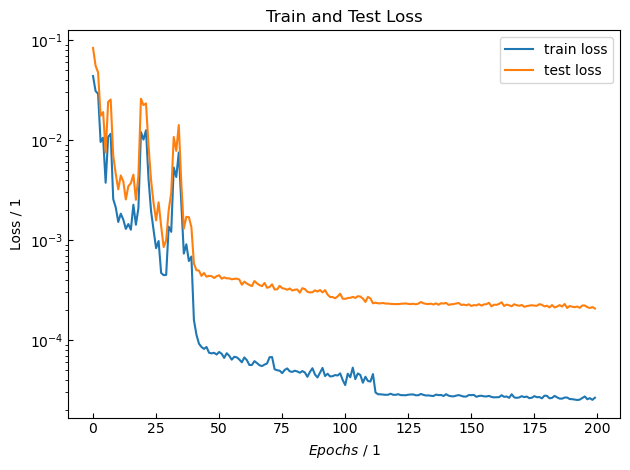

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2(H2) = 0.9999836948194509 , R^2(NH3) = 0.9999632292912886
Test Dataset: R^2(H2) = 0.9999497415245444 , R^2(NH3) = 0.9997587067960503
Max Error Training: |x_H2 - x_H2,pred| = 0.008397193552470206 , |x_NH3 - x_NH3,pred| = 0.006386024701193982
Max Error Test: |x_H2 - x_H2,pred| = 0.008445474518124718 , |x_NH3 - x_NH3,pred| = 0.020650700327376703


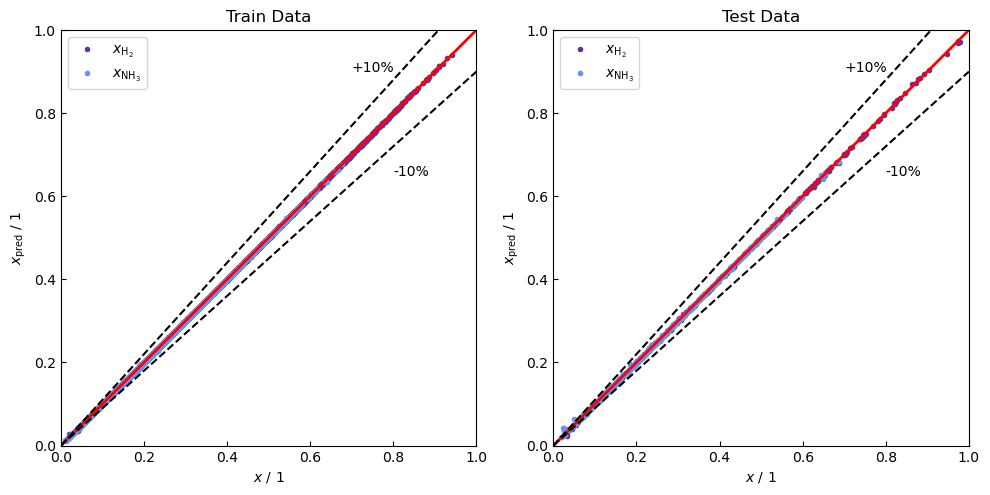

In [11]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

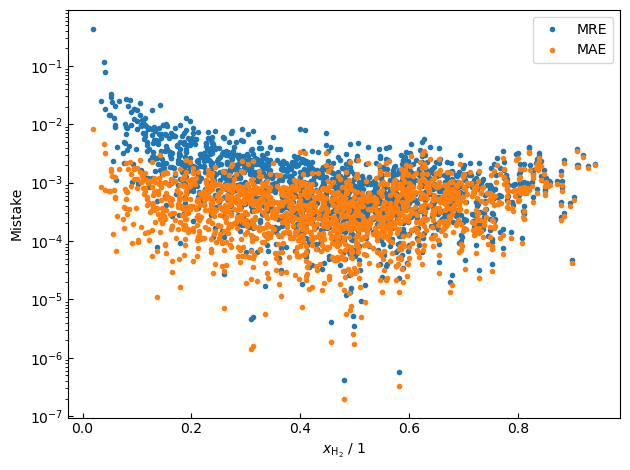

In [12]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

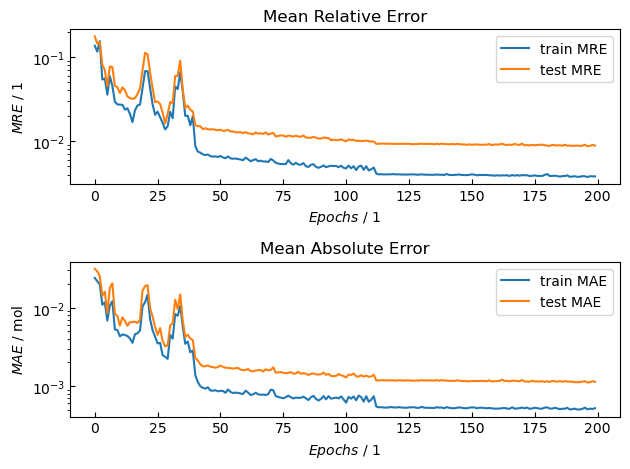

In [13]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

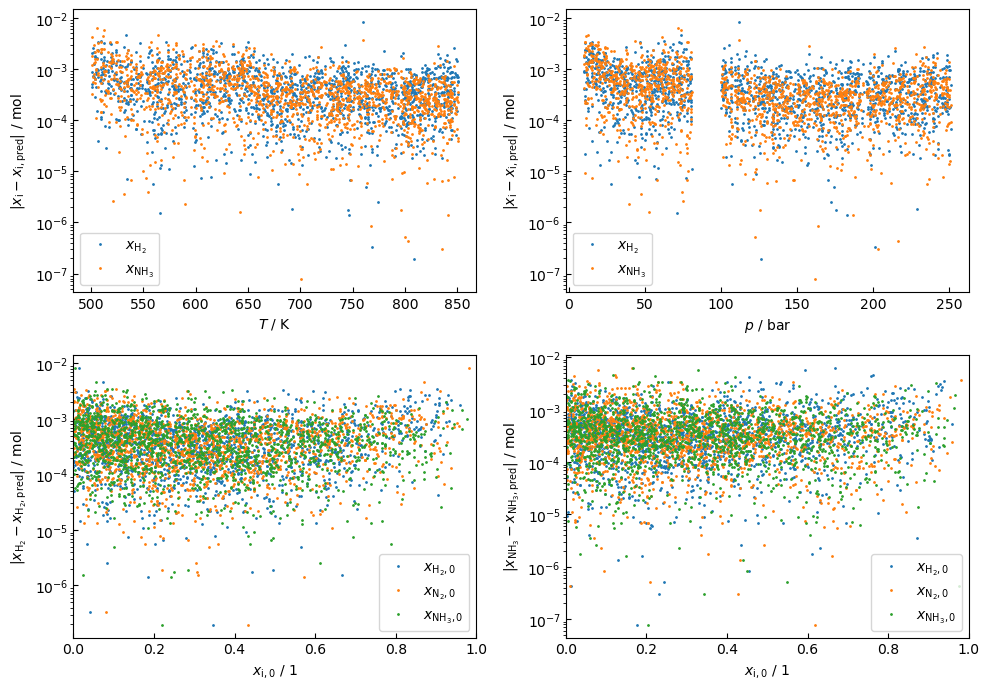

In [14]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

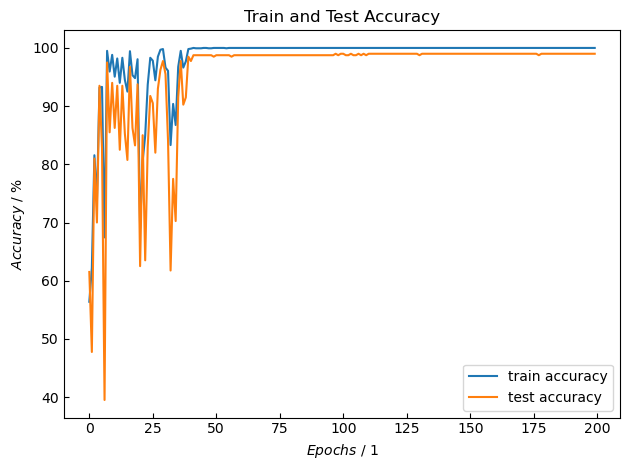

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Laufzeit Gleichgewichtsvorhersage

In [16]:
start_pred_time = time.process_time()
for X, y in train_dataloader:
            pred = net(X)
pred_time = (time.process_time() - start_pred_time)
print('Prediction time:', pred_time, 's')

Prediction time: 0.171875 s


#### Debugging Hilfe

In [17]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[ 0.3943,  1.3913, -1.3749,  2.6018, -1.2145],
        [ 1.3882,  0.5974, -0.5548,  0.5657, -0.0105],
        [ 0.1255,  1.4144, -0.1328,  0.8012, -0.6620],
        [-1.7614, -1.4518,  1.1360, -0.2289, -0.8991],
        [-0.1028,  1.1095, -1.1260,  1.7839, -0.6511],
        [-1.1664, -1.5371,  2.3999, -1.3796, -1.0118],
        [ 0.7516, -0.3140, -0.8084, -0.1419,  0.9417],
        [ 1.0645,  0.2100, -0.1309,  0.7182, -0.5816],
        [ 0.2073,  1.5681, -0.7035,  1.7711, -1.0570],
        [ 0.7529,  0.2479, -1.1066, -1.0531,  2.1398],
        [ 0.6869,  0.8583,  2.0718, -1.1169, -0.9469],
        [ 1.1452, -0.1425, -1.0550,  2.2068, -1.1403],
        [-0.3928, -0.8363, -1.1660, -0.5206,  1.6712],
        [ 0.1739,  1.5060, -0.5439,  1.4691, -0.9162],
        [-1.6866, -1.1789, -0.6933, -0.9486,  1.6267],
        [-0.4058, -1.2233,  2.5214, -1.3055, -1.2056],
        [-0.8822, -1.0557,  0.9501, -0.0475, -0.8946],
        [ 0.0336, -0.2191,  2.4228, -1.0955, -1.3161],
        [ 

#### Einblick in Netzwerk

In [18]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[-9.8385e-02,  1.4911e-01, -3.0762e-01,  1.8414e-02, -2.4299e-01],
         [-1.0713e-01, -5.1300e-02, -3.1888e-01, -1.8821e-01, -2.8320e-01],
         [ 4.4847e-01, -6.2343e-02, -1.8250e-01, -1.7455e-01,  1.6243e-01],
         [ 3.8165e-01, -1.6326e-01,  3.1184e-01,  3.3038e-01,  3.7709e-01],
         [-1.7485e-01, -2.1695e-01, -2.1520e-01, -1.2245e-02, -2.3403e-01],
         [ 6.9668e-02, -2.2872e-01,  2.9638e-01, -9.6673e-02, -2.0612e-01],
         [ 1.8670e-01, -1.4632e-01, -1.6976e-01, -1.5098e-01, -1.5238e-01],
         [-3.7269e-02,  2.9330e-02, -3.0348e-01, -6.6926e-02, -2.9630e-01],
         [-1.6331e-01,  7.6480e-02, -5.9679e-02,  3.5289e-01,  4.4292e-03],
         [-1.5517e-01,  2.7197e-01, -1.8638e-01,  3.2248e-01, -2.0672e-02],
         [-1.2426e-01, -9.4612e-02,  2.0012e-01, -1.7963e-01,  9.8173e-02],
         [ 9.9142e-02, -2.8985e-02, -5.5204e-02,  5.3156e-02,  1.0637e-02],
         [ 3.7487e-01,  2.7442e-01,  5.4617e-02, -2.5623e-01,  1.

In [19]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.7675, 0.5383, 0.9186, 0.0894, 0.8630],
        [0.4280, 0.1492, 0.2974, 0.3587, 0.8174]])
tensor([[ 0.7959, -0.2971],
        [ 0.3370, -0.2169]], grad_fn=<AddmmBackward0>)


In [20]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [21]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    #print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[-0.2945,  0.1368, -0.5852,  1.2907, -0.6984],
        [-0.8120, -0.7289,  0.8650, -0.9505,  0.0842],
        [ 1.2699,  0.1892, -1.2552, -0.9769,  2.2115],
        [ 0.2841,  0.3965, -1.0707, -0.5030,  1.5593],
        [-0.8651, -0.7018, -1.0592,  0.2197,  0.8321],
        [ 0.6047,  0.3740, -0.6948,  0.5416,  0.1521],
        [-0.6949, -1.5313, -1.1495, -0.6553,  1.7883],
        [-0.6829, -1.1676, -0.7366, -1.3718,  2.0887],
        [ 0.9738,  0.7390, -1.3436,  2.1626, -0.8105],
        [-1.6283, -0.6611,  0.8366, -0.4167, -0.4164],
        [ 1.2718,  1.0727,  1.2425, -0.4978, -0.7382],
        [-0.7785, -0.8646,  1.1709, -0.8060, -0.3620],
        [ 1.5327, -0.1491,  0.4824, -0.7804,  0.2949],
        [ 0.8159,  1.6412, -0.9479, -0.0852,  1.0238],
        [ 1.4946,  1.0957, -0.6354,  2.0170, -1.3682],
        [ 0.5433,  1.4700, -0.2179,  1.3329, -1.1043],
        [-0.1852,  0.6683, -0.0127, -0.2829,  0.2928],
        [ 0.2662,  1.2457, -0.9193,  0.7593,  0.1590],
        [-

#### Histogramme Verteilung von $xi$ und $x{_i}$

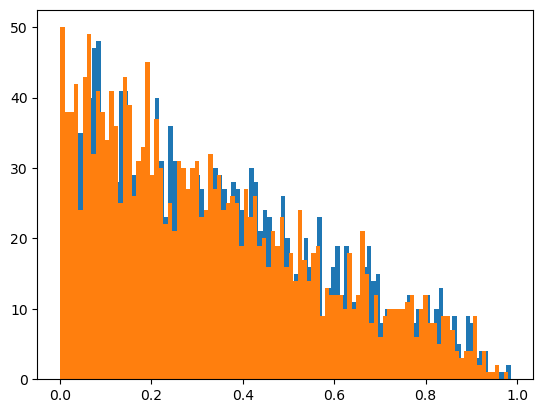

In [22]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()

#### Speichern des Modells

In [23]:
# torch.save(net.state_dict(),'data/models/ann_005_021.pth')
# np.savez('data/models/params_005_021.npz', mean_in = mean_in, std_in = std_in, mean_out = mean_out, std_out = std_out)